<a href="https://colab.research.google.com/github/palakagl/DeepLearning/blob/main/TACO_Dataset_Cat_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Uncomment only for first run
!pip install neptune-client neptune-tensorflow-keras tensorflow

     |████████████████████████████████| 315 kB 3.2 MB/s 
     |████████████████████████████████| 829 kB 37.2 MB/s 
     |████████████████████████████████| 54 kB 2.2 MB/s 
     |████████████████████████████████| 181 kB 33.1 MB/s 
     |████████████████████████████████| 132 kB 43.4 MB/s 
     |████████████████████████████████| 79 kB 3.7 MB/s 
     |████████████████████████████████| 8.6 MB 34.4 MB/s 
     |████████████████████████████████| 138 kB 44.2 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 127 kB 45.3 MB/s 
     |████████████████████████████████| 462 kB 53.6 MB/s 
     |████████████████████████████████| 67 kB 4.7 MB/s 
     |████████████████████████████████| 130 kB 71.2 MB/s 
     |████████████████████████████████| 64 kB 2.6 MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.15.2-py2.py3-none-any.whl size=565173 sha256=459ba29d9d0b1354500019ec96a1d7e175c54ab880791dece7147858a33c4b7f
  Stored in directory: /roo

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

import neptune.new as neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback

import cv2
from google.colab.patches import cv2_imshow      # To show images using cv2 module
from pycocotools.coco import COCO

import pathlib
import os

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Input, Dropout
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Flatten

from keras.preprocessing.image import ImageDataGenerator

import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.8.0
Hub version: 0.12.0
GPU is NOT AVAILABLE


In [4]:
# Mount Google drive so dataset can be accessed
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
run = neptune.init(
    project="palakagl/TACO-Dataset",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIwYjM0NzcxZi0xYjY1LTRmZWQtOTNmNC1iNjYyNTdkYTBmMWYifQ==",
) 

https://app.neptune.ai/palakagl/TACO-Dataset/e/TAC-5


Info (NVML): Driver Not Loaded. GPU usage metrics may not be reported. For more information, see https://docs.neptune.ai/you-should-know/what-can-you-log-and-display#hardware-consumption


Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [6]:
  # Select base model  for transfer learning
model_name = "efficientnet_v2_50" # @param [ 'efficientnet_v2_50', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152',  'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

model_handle_map = {
    "efficientnet_v2_50": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",   
    "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
    "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
    "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
    "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
    "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature_vector/5",
    "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
    "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
    "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
    "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
    "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
    "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
    "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
    "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
    "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
    "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
    "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
  }

PIXELS = 224#@param {type:"integer"}
BATCH_SIZE = 32#@param {type:"integer"}

model_handle = model_handle_map.get(model_name)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (PIXELS, PIXELS)
print(f"Input size {IMAGE_SIZE}")


Selected model: efficientnet_v2_50 : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2
Input size (224, 224)


In [7]:
#Log to NeptuneAI
run["model/transferlearning/model_name"] = model_name
#run["model/transferlearning/model_url"] = model_handle
run["model/transferlearning/model_batch_size"] = BATCH_SIZE
run["model/parameters/image_size"] = IMAGE_SIZE

In [8]:
def load_data(save_dir="./"):

  dir_path = '/content/drive/MyDrive/MMAI_894/TACO_Dataset/data/Final_Dataset/'
  
  datagen_kwargs = dict(rescale=1./255, validation_split=0.2)

  dataflow_kwargs = dict(target_size=(PIXELS, PIXELS), 
                        batch_size=BATCH_SIZE,
                        class_mode="categorical",
                        )

  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      horizontal_flip=True, vertical_flip=True, rotation_range=90,
      **datagen_kwargs)
  train_generator = train_datagen.flow_from_directory(dir_path, 
                                            subset='training',
                                            seed=11,
                                            interpolation='nearest',
                                            **dataflow_kwargs
                                            )

  val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      **datagen_kwargs)
  val_generator = val_datagen.flow_from_directory(dir_path, 
                                            subset='validation',
                                            seed=11,
                                            interpolation='nearest',
                                            **dataflow_kwargs
                                            )
  return val_generator, train_generator

VAL_generator, TRAIN_generator = load_data()

Found 1564 images belonging to 5 classes.
Found 389 images belonging to 5 classes.


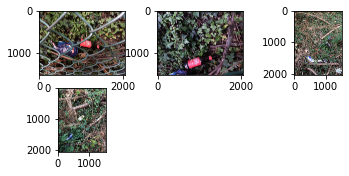

In [9]:
# plot the first 9 images in the planet dataset
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
folder = '/content/drive/MyDrive/MMAI_894/TACO_Dataset/data/Final_Dataset/Plastic/'
# plot first few images
for i in range(4):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# define filename
	filename = folder + 'batch_1_0000' + str(i+21) + '.jpg'
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

In [10]:
def define_model(in_shape=(224, 224, 3), out_shape=5):
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(out_shape, activation='sigmoid'))
	return model
 
model = define_model()

In [11]:
print("Building model with", model_handle)
def build_model_with_transfer_learning(trainable=False, params={}):

    #imports the mobilenet model and discards the last 1000 neuron layer.
   #base_model=keras.applications.MobileNetV2(weights='imagenet',
   #                                          include_top=False,
   #                                          input_shape=IMAGE_SIZE+(3,))

   # base_model.trainable = False                                      

   inputs = keras.Input(shape=IMAGE_SIZE+(3,))
   x = hub.KerasLayer(model_handle, trainable=trainable)
  #x = base_model(inputs, training=False)
   x = keras.layers.GlobalAveragePooling2D()(x)
   x=Dense(params['dense_units_1'],activation=params['dense_layer_activation_1'])(x)
   x=Dropout(params['dropout_1'])(x)
   x=Dense(params['dense_units_2'],activation=params['dense_layer_activation_2'])(x)
   x=Dropout(params['dropout_2'])(x)
   x = Flatten()(x)
   x=Dense(params['dense_units_2'],activation=params['dense_layer_activation_2'])(x)
   outputs = keras.layers.Dense(59, activation=params['final_layer_activation'])(x)
   model = keras.Model(inputs, outputs)

   return model

model.summary()

params = {
    "dense_units_1": 512,
    "dense_layer_activation_1": "relu",
    "dropout_1": 0.3,    
    "dense_units_2": 128,
    "dense_layer_activation_2": "relu",
    "dropout_2": 0.1,
    "final_layer_activation": "sigmoid",
    "learning_rate": 1e-2,
    "n_epochs": 50,    
    "regularizer_rate":0.005
}
run["model/parameters"] = params
#model = build_model_with_transfer_learning(params=params)

Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (Max

In [12]:
from keras import backend
 
# calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
	# clip predictions
	y_pred = backend.clip(y_pred, 0, 1)
	# calculate elements
	tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
	fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
	fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
	# calculate precision
	p = tp / (tp + fp + backend.epsilon())
	# calculate recall
	r = tp / (tp + fn + backend.epsilon())
	# calculate fbeta, averaged across each class
	bb = beta ** 2
	fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
	return fbeta_score

In [13]:
def compile_model(model):
  model.compile(
    optimizer=tf.keras.optimizers.RMSprop(), 
  loss=keras.losses.BinaryCrossentropy(),
  metrics=['accuracy'])
  return model

model = compile_model(model)

In [ ]:
def train_model(model, num_epochs):
    steps_per_epoch = TRAIN_generator.samples // TRAIN_generator.batch_size
    validation_steps = VAL_generator.samples // VAL_generator.batch_size

    history = model.fit(
      TRAIN_generator,
      epochs=num_epochs, steps_per_epoch=steps_per_epoch,
      validation_data = VAL_generator,
      validation_steps = validation_steps,
     #callbacks=[NeptuneCallback(run=run),EarlyStoppingCallback]
     ).history
    
    return model, history

model, history = train_model(model, num_epochs=5)

Epoch 1/5
 2/48 [>.............................] - ETA: 13:29 - loss: 37.9112 - accuracy: 0.4219

In [ ]:
plt.figure()
plt.ylabel("fbeta (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(history["fbeta"])
plt.plot(history["val_fbeta"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(history["accuracy"])
plt.plot(history["val_accuracy"])

In [ ]:
# define filename
filename = '/content/drive/MyDrive/Colab Notebooks/data/trash/Aerosol/batch_1_000054.jpg'

img = tf.keras.preprocessing.image.load_img(
    filename, target_size=(224, 224)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
print(predictions)
score = tf.nn.sigmoid(predictions[0])
print(score)
print(list(class_names))
print( "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(list(class_names)[np.argmax(score)], 100 * np.max(score)) )

In [ ]:
# Generate predictions
model.load_weights('/content/drive/MyDrive/Colab Notebooks/Models/garbageclassification_model_checkpoint/resnet_best_weights.hdf5') # initialize the best trained weights
preds = model.predict(test_ds)
pred_classes = np.argmax(preds, axis = 1)

In [ ]:
saved_model_path = "/content/drive/MyDrive/Colab Notebooks/Models/saved_garbageclassification_model"
tf.saved_model.save(model, saved_model_path)

In [ ]:
# Add Callbacks

# Model Checkpoint
tl_checkpoint_1 = ModelCheckpoint(filepath = '/content/drive/MyDrive/Colab Notebooks/Models/garbageclassification_model_checkpoint/resnet_best_weights.hdf5', save_best_only = True, verbose = 0)

# Early Stopping Checkpoint
EarlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)